In [1]:
%%time

import glob
import json
import pandas as pd
import tensorflow as tf
import spacy
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Flatten, Concatenate, TimeDistributed, Bidirectional, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow import TensorShape
import tensorflow_addons as tfa

CPU times: user 1.75 s, sys: 520 ms, total: 2.27 s
Wall time: 1.75 s


In [2]:
%%time

path = '/home/prajakta/Documents/SharpestMinds/COVID-analysis/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])
filter = data.abstract != ""
data = data[filter][:15]
data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))
data.query('len_bt <= 10000 and len_ab <= 500', inplace = True)
#first_10 = data[:10]

CPU times: user 2.6 s, sys: 696 ms, total: 3.3 s
Wall time: 3.3 s


In [3]:
data.describe()

,len_bt,len_ab
count,14.000000,14.000000
mean,4421.928571,236.285714
std,1664.263823,76.121794
min,2062.000000,48.000000
25%,3556.500000,221.750000
50%,4096.500000,256.500000
75%,5369.250000,274.750000
max,7861.000000,352.000000


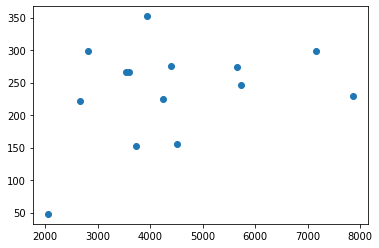

In [4]:
plt.scatter(data.len_bt,data.len_ab)

In [5]:
def clean_text(bodytext):
    cleaned = list()
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for word in bodytext:
        words = str(word)       
        words = words.lower()
        words = words.translate(table)
        words = re_print.sub('', words) 
        if words.isalpha() == True:
            cleaned.append(words)
    cleaned.insert(0, '<start>')
    cleaned.append('<end>')
    return cleaned

In [6]:
nlp = spacy.load("en_core_web_sm")
bt_vector = list()
bt_list = []
ab_list = []
for i in range(len(data)):
    bodytext = nlp(data.iloc[i].bodytext)
    bt_clean = clean_text(bodytext)
    bt_list.append(bt_clean)
    
    abstract = nlp(data.iloc[i].abstract)
    ab_clean = clean_text(abstract)
    ab_list.append(ab_clean)
com_list = ab_list + bt_list
    #c_papers.append(papers)
bt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
bt_tokenizer.fit_on_texts(com_list)
data_bt = bt_tokenizer.texts_to_sequences(bt_list)
data_ab = bt_tokenizer.texts_to_sequences(ab_list)

longest_seq = max(max([len(x) for x in data_bt]), max([len(x) for x in data_ab]))
#x_voc_size = max([len(x) for x in data_bt])#, max([len(x) for x in data_ab]))
#y_voc_size = max([len(y) for y in data_ab])
data_bt = tf.keras.preprocessing.sequence.pad_sequences(data_bt,padding='post', maxlen = longest_seq)
data_ab = tf.keras.preprocessing.sequence.pad_sequences(data_ab,padding='post', maxlen = longest_seq) 

In [7]:
def max_len(tensor):
    #print( np.argmax([len(t) for t in tensor]))
    return max( len(t) for t in tensor)

In [8]:
#dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
X_train,  X_test, Y_train, Y_test = train_test_split(data_bt,data_ab,test_size=0.2)
BATCH_SIZE = 5
BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32 

In [9]:
vocab_size = len(bt_tokenizer.word_index)+1  

In [10]:
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]
encoder_initial_cell_state = initialize_initial_state()

In [34]:
lstm

<tf.Tensor 'bidirectional_4/Identity:0' shape=(None, 7143, 256) dtype=float32>

In [55]:
inputs = Input(shape=(longest_seq,))
encoder1 = Embedding(vocab_size, 128)(inputs)
encoder2, state_h, state_c  = LSTM(128, return_sequences=True, return_state = True)(encoder1)
enc_states = [state_h, state_c]

# decoder output model
dec_input = Input(shape = (longest_seq,))
decoder_lstm,_, _ = LSTM(128, return_sequences=True, return_state=True)(dec_input, initial_state = enc_states)
#decoder_outputs, _, _ = decoder_lstm(dec_input)
#decoder1 = LSTM(128)(encoder2)
outputs = Dense(longest_seq, activation='softmax')(decoder_lstm)

# tie it together
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#Y_train = Reshape(1,length, 1)
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=2, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=1)
test_scores
#print("Test loss:", test_scores[0])
#print("Test accuracy:", test_scores[1])

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 7143)]       0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 7143, 128)    763264      input_29[0][0]                   
__________________________________________________________________________________________________
lstm_45 (LSTM)                  [(None, 7143, 128),  131584      embedding_20[0][0]               
__________________________________________________________________________________________________
lstm_46 (LSTM)                  [(None, 7143, 128),  131584      lstm_45[0][0]                    
                                                                 lstm_45[0][1]              

In [51]:
p_data = data_bt[0].reshape(1,-1)
summary = model.predict(p_data)

In [52]:
summary.shape

(1, 7143, 7143)

In [ ]:
data.abstract[data.paper_id == '1b8770691fe974dfb269a16db59750370b9c0c21']

In [54]:
indexes = tf.math.argmax(summary, axis=0).numpy()
words = [bt_tokenizer.index_word[x] for x in indexes if x!=0 ]
" ".join(words)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

inputs = Input(shape=(longest_seq,))
encoder1 = Embedding(vocab_size, 128)(inputs)
enc_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM
                                     (128,
                                      dropout=0.3,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_activation='relu',
                                      recurrent_initializer='glorot_uniform'), name="bi_lstm_0")(encoder1)

lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional \
    (tf.keras.layers.LSTM
     (128,
      dropout=0.2,
      return_sequences=True,
      return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(enc_lstm)

state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

#dec_inputs = Input(shape=(longest_seq,))
dec_lstm = LSTM(256,return_sequences=True,
                                      return_state=True)(lstm)

attn_layer = Attention(name='attention_layer')
attn_out, attn_states = attn_layer([lstm, dec_lstm[0]])

#context_vector, attention_weights = Attention(256)([lstm, state_h])

# decoder output model

outputs = Dense(longest_seq, activation='softmax')(attn_out)



# tie it together
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#Y_train = Reshape(1,length, 1)
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=2, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=1)
test_scores
#print("Test loss:", test_scores[0])
#print("Test accuracy:", test_scores[1])